# DES Y1 Mass-Richness Calibration

Compare Capish theoretical predictions against DES Y1 cluster observations.

- Survey area: 1603.5 deg²
- Richness bins: [20-30, 30-45, 45-60, 60-200] (includes highest richness bin)
- Redshift bins: [0.2-0.35, 0.35-0.5, 0.5-0.65]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import sys
import os
import configparser

# Add modules to path
root_path = os.path.abspath('../../')
sys.path.insert(0, root_path)
from modules.simulation import UniverseSimulator

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Imports loaded successfully")

## Load DES Y1 Data

In [ ]:
# Load DES Y1 RedMaPPer catalogue
file_path = '/sps/euclid/Users/cmurray/clusters_likelihood/redmapper_y1a1_public_v6.4_catalog.fits.gz'
redmapper_catalogue = Table.read(file_path, format='fits')
redmapper_catalogue.remove_columns(['P_CEN', 'RA_CEN', 'DEC_CEN', 'ID_CEN', 'PZBINS', 'PZ'])
redmapper_catalogue = redmapper_catalogue.to_pandas()

# Define binning (now including the highest richness bin)
lambda_bins = np.array([20, 30, 45, 60, 200])
z_bins = np.array([0.2, 0.35, 0.5, 0.65])
lambda_cents = np.array([25.0, 37.5, 52.5, 130.0])

n_lambda_bins = len(lambda_bins) - 1
n_z_bins = len(z_bins) - 1

print(f"Loaded {len(redmapper_catalogue)} clusters")
print(f"Richness bins: {lambda_bins}")
print(f"Redshift bins: {z_bins}")
print(f"Total calibration bins: {n_lambda_bins * n_z_bins}")

Loaded 6729 clusters
Richness bins: [ 20  30  45  60 200]
Redshift bins: [0.2  0.35 0.5  0.65]
Total calibration bins: 12


In [ ]:
# Extract DES observed counts
des_counts = np.zeros((n_z_bins, n_lambda_bins))
for i in range(n_z_bins):
    z_mask = (redmapper_catalogue['Z_LAMBDA'] >= z_bins[i]) & (redmapper_catalogue['Z_LAMBDA'] < z_bins[i+1])
    counts, _ = np.histogram(redmapper_catalogue['LAMBDA'][z_mask], bins=lambda_bins)
    des_counts[i] = counts

# DES mean masses (with h correction) - extended to include highest richness bin
des_masses = np.array([
    [14.036, 14.323, 14.454, 14.650],  # z: 0.2-0.35, added estimate for λ>60
    [14.007, 14.291, 14.488, 14.680],  # z: 0.35-0.5, added estimate for λ>60
    [13.929, 14.301, 14.493, 14.700]   # z: 0.5-0.65, added estimate for λ>60
]) + np.log10(0.744)  # h correction

# Mass uncertainties - extended to include highest richness bin
des_mass_errors = np.array([
    [0.077, 0.082, 0.094, 0.150],  # Combined stat + sys, larger error for λ>60
    [0.089, 0.092, 0.109, 0.160],  # due to smaller sample size
    [0.120, 0.127, 0.124, 0.180]
])

print(f"DES observed counts:")
print(des_counts)
print(f"\nTotal observed clusters: {des_counts.sum()}")

DES observed counts:
[[ 762.  376.  123.   91.]
 [1549.  672.  187.  147.]
 [1612.  687.  205.   92.]]

Total observed clusters: 6503.0


## Run Capish Simulation

In [ ]:
def create_capish_config(mr_params, cosmo_params, area_sr):
    """Create Capish configuration."""
    config = configparser.ConfigParser()
    
    # Unified parameters
    config['parameters'] = {**cosmo_params, **mr_params}
    
    # Halo catalogue
    config['halo_catalogue'] = {
        'hmf_name': 'Tinker10',
        'bias_model': 'Tinker10',
        'sky_area': str(area_sr),
        'log10m_min': '13.0',
        'log10m_max': '16.0',
        'n_mass_bins': '1000',
        'z_min': '0.1',
        'z_max': '0.8',
        'n_redshift_bins': '700',
        'SSC': 'False',
        'mass_def_overdensity_type': 'critical',
        'mass_def_overdensity_delta': '200',
        'Mstar': '10',
        's': '0.0',
        'q': '1.0',
        'recompute_SSC_ficucial': 'False',
        'name_sigma2ij_fullsky_file': 'sigma2ij_fullsky_fiducial_zmin={}_zmax={}_nzbins={}.pkl',
        'save_new_SSC_fiducial': 'False',
        'Omega_c_fiducial': '0.25',
        'Omega_b_fiducial': '0.049',
        'h_fiducial': '0.674',
        'sigma_8_fiducial': '0.811',
        'n_s_fiducial': '0.965'
    }
    
    # Cluster catalogue
    config['cluster_catalogue'] = {
        'add_completeness': 'False',
        'params_completeness': '1.0, 0.0, 14.0, 0.0',
        'add_photometric_redshift': 'False',
        'add_purity': 'False',
        'params_purity': '1.0, 0.0, 2.0, 0.0',
        'add_selection': 'False'
    }
    
    config['cluster_catalogue.mass_observable_relation'] = {
        'which_relation': 'Gauss+Poiss-corr'
    }
    
    config['cluster_catalogue.photometric_redshift'] = {
        'sigma_z0': '0.02'
    }
    
    # Summary statistics - updated for 4 richness bins (comma-separated without spaces)
    config['summary_statistics'] = {
        'summary_statistic': 'binned_count_mean_mass',
        'Gamma': 2/3,
        'richness_edges': ','.join(map(str, lambda_bins)),
        'redshift_edges': ','.join(map(str, z_bins)),
    }
    
    return config


In [ ]:
# Mass-richness relation parameters (adjust these for calibration)
MASS_RICHNESS_PARAMS = {
    'pivot_obs_z0': 0.35,
    'pivot_obs_log10m0': 14.1,
    'mu_0_lambda': 3.2,
    'mu_z_lambda': 0.0,
    'mu_m_lambda': 3.0,
    'sigma_lambda': 0.25,
    'mu_0_Mwl': 0.0,
    'mu_m_Mwl': 1.0,
    'mu_z_Mwl': 0.0,
    'sigma_Mwl_gal': 0.2,
    'sigma_Mwl_int': 0.2,
    'rho': 0.2
}

# Cosmological parameters
COSMO_PARAMS = {
    'Omega_m': 0.18,
    'sigma8': 0.85,
    'Omega_b': 0.049,
    'h': 0.674,
    'ns': 0.965,
    'w0': -1,
    'wa': 0
}

# DES survey area
DES_AREA_DEG2 = 1453.6
DES_AREA_SR = DES_AREA_DEG2 * (np.pi/180)**2

print(f"DES survey area: {DES_AREA_DEG2} deg² ({DES_AREA_SR:.6f} sr)")

DES survey area: 1453.6 deg² (0.442792 sr)


In [ ]:
config = create_capish_config(MASS_RICHNESS_PARAMS, COSMO_PARAMS, DES_AREA_SR)
print("Capish configuration created")

Capish configuration created


In [ ]:
# Run simulation
simulator = UniverseSimulator(default_config=config, variable_params_names=['Omega_m', 'sigma8'])
fiducial_values = [COSMO_PARAMS['Omega_m'], COSMO_PARAMS['sigma8']]

print(f"Running simulation with Ωm={fiducial_values[0]}, σ8={fiducial_values[1]}")
print(f"Expected output shape: {n_z_bins} x {n_lambda_bins} = {n_z_bins}x{n_lambda_bins}")
summary_stats = simulator.run_simulation(fiducial_values)

print(f"Simulation complete. Results type: {type(summary_stats)}")
if hasattr(summary_stats, 'shape'):
    print(f"Results shape: {summary_stats.shape}")
elif isinstance(summary_stats, tuple):
    print(f"Tuple with {len(summary_stats)} items:")
    for i, item in enumerate(summary_stats):
        print(f"  Item {i}: shape = {item.shape if hasattr(item, 'shape') else 'N/A'}")

Running simulation with Ωm=0.18, σ8=0.85
Expected output shape: 3 x 4 = 3x4


In [ ]:
def summary_statistic_to_sensible_format(summary_statistic, n_z=3, n_lambda=4):
    """Format Capish results - now returns tuple (count_stat, mass_stat)."""
    
    if isinstance(summary_statistic, tuple) and len(summary_statistic) == 2:
        # New format: tuple of (counts, masses) 
        count_stat, mass_stat = summary_statistic
        sim_n_clusters = np.array(count_stat)
        sim_mwl_mean = np.array(mass_stat)
        
        # Check if we need to transpose - Capish returns (n_lambda, n_z) but we want (n_z, n_lambda)
        if sim_n_clusters.shape == (n_lambda, n_z):
            sim_n_clusters = sim_n_clusters.T
            sim_mwl_mean = sim_mwl_mean.T
            
    else:
        # Old format: flat array
        n_total_bins = n_z * n_lambda
        sim_n_clusters = summary_statistic[:n_total_bins].reshape(n_z, n_lambda)
        sim_mwl_mean = summary_statistic[n_total_bins:].reshape(n_z, n_lambda)
    
    return sim_n_clusters, sim_mwl_mean

# Format the Capish results
capish_counts, capish_masses = summary_statistic_to_sensible_format(summary_stats, n_z_bins, n_lambda_bins)

print(f"Summary stats type: {type(summary_stats)}")
if isinstance(summary_stats, tuple):
    print(f"Tuple length: {len(summary_stats)}")
    for i, item in enumerate(summary_stats):
        print(f"  Item {i}: type={type(item)}, shape={getattr(item, 'shape', 'N/A')}")

print(f"Raw Capish results shape: {summary_stats[0].shape}")
print(f"Capish counts shape after formatting: {capish_counts.shape}")
print(f"Capish masses shape after formatting: {capish_masses.shape}")
print(f"Capish counts:\n{capish_counts}")
print(f"Capish masses:\n{capish_masses}")

Summary stats type: <class 'tuple'>
Tuple length: 2
  Item 0: type=<class 'numpy.ndarray'>, shape=(4, 3)
  Item 1: type=<class 'numpy.ndarray'>, shape=(4, 3)
Raw Capish results shape: (4, 3)
Capish counts shape after formatting: (3, 4)
Capish masses shape after formatting: (3, 4)
Capish counts:
[[ 455.  274.  152.  232.]
 [ 875.  553.  220.  382.]
 [1329.  780.  342.  467.]]
Capish masses:
[[14.12472846 14.2717491  14.40460699 14.59875772]
 [14.13605333 14.26704035 14.39559132 14.58755906]
 [14.12589053 14.26825639 14.39043551 14.57925793]]


## Tutorial-Style Comparison Plot

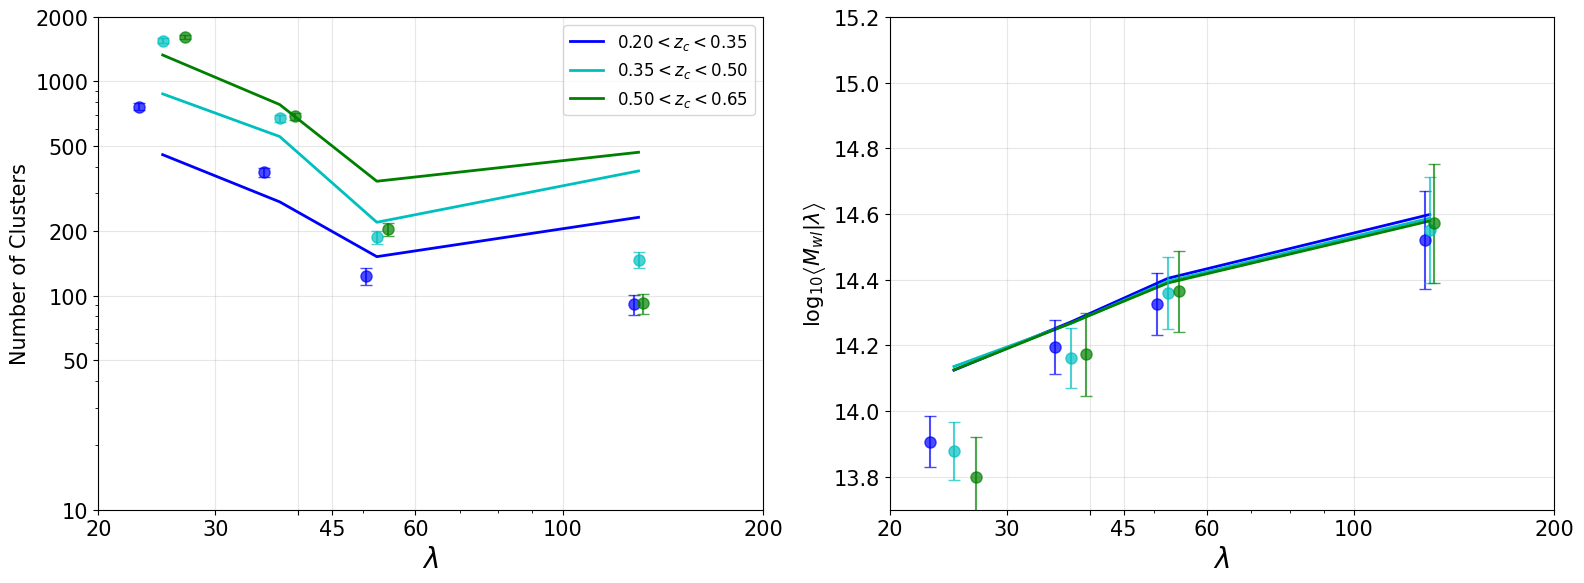


CAPISH vs DES Y1 COMPARISON

z-bin 1 (0.20-0.35):
  DES counts:     [762. 376. 123.  91.]
  Capish counts:  [455 274 152 232]
  DES masses:     [13.908, 14.195, 14.326, 14.522]
  Capish masses:  [14.125, 14.272, 14.405, 14.599]

z-bin 2 (0.35-0.50):
  DES counts:     [1549.  672.  187.  147.]
  Capish counts:  [875 553 220 382]
  DES masses:     [13.879, 14.163, 14.36 , 14.552]
  Capish masses:  [14.136, 14.267, 14.396, 14.588]

z-bin 3 (0.50-0.65):
  DES counts:     [1612.  687.  205.   92.]
  Capish counts:  [1329  780  342  467]
  DES masses:     [13.801, 14.173, 14.365, 14.572]
  Capish masses:  [14.126, 14.268, 14.39 , 14.579]


In [ ]:
# Set the figure size
plt.figure(figsize=(16, 6))

# Colors and labels for redshift bins
colors = ['b-', 'c-', 'g-']
z_labels = ['$ 0.20 < z_c < 0.35 $', '$ 0.35 < z_c < 0.50 $', '$ 0.50 < z_c < 0.65 $']

# Subplot 1: Number of clusters
plt.subplot(121)

# Plot Capish predictions
for i in range(n_z_bins):
    plt.plot(lambda_cents, capish_counts[i, :], colors[i], linewidth=2, label=z_labels[i])

# Plot DES observations as points
for i in range(n_z_bins):
    count_errors = np.sqrt(np.maximum(des_counts[i, :], 1))
    plt.errorbar(lambda_cents + (i-1)*2, des_counts[i, :], yerr=count_errors,
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.yticks([10, 50, 100, 200, 500, 1000, 2000], labels=[10, 50, 100, 200, 500, 1000, 2000])
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Number of Clusters', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(ticks=[20, 30, 40, 45, 60, 100, 200],
           labels=[20, 30, None, 45, 60, 100, 200], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

# Subplot 2: Mean MWL
plt.subplot(122)

# Plot Capish predictions
for i in range(n_z_bins):
    plt.plot(lambda_cents, capish_masses[i, :], colors[i], linewidth=2, label=z_labels[i])

# Plot DES observations as points
for i in range(n_z_bins):
    plt.errorbar(lambda_cents + (i-1)*2, des_masses[i, :], yerr=des_mass_errors[i, :],
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7)

plt.xscale('log')
plt.ylim(13.7, 15.2)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'log$_{10} \left< M_{wl} | \lambda \right>$', fontsize=15)
plt.xticks(ticks=[20, 30, 40, 45, 60, 100, 200],
           labels=[20, 30, None, 45, 60, 100, 200], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("CAPISH vs DES Y1 COMPARISON")
print("="*60)
for i in range(n_z_bins):
    print(f"\nz-bin {i+1} ({z_bins[i]:.2f}-{z_bins[i+1]:.2f}):")
    print(f"  DES counts:     {des_counts[i, :]}")
    print(f"  Capish counts:  {capish_counts[i, :].astype(int)}")
    print(f"  DES masses:     {np.array2string(des_masses[i, :], precision=3, separator=', ')}")
    print(f"  Capish masses:  {np.array2string(capish_masses[i, :], precision=3, separator=', ')}")

## Parameter Iteration

Modify `MASS_RICHNESS_PARAMS` above and re-run cells to calibrate parameters.

In [ ]:
# Example parameter modifications:
# MASS_RICHNESS_PARAMS['mu_0_lambda'] = 3.0      # Reduce normalization
# MASS_RICHNESS_PARAMS['mu_m_lambda'] = 1.2      # Increase mass scaling

print("Current parameters:")
for key, value in MASS_RICHNESS_PARAMS.items():
    print(f"  {key}: {value}")